### SUMMARY
- optimizer matters! using Ranger with step_size = 600 gives the best result. 
- The step decrease in learning rate really matters! (try step at 75% v.s. at 600 step)
- No. of epochs matter (1000 v.s. 2000)
- Sometimes it got trapped at local minima (i.e. 0.200 loss level)
- The longer the sequence, the harder it is to be optimized
- no. of layers doesn't really matter.
- to determine the optimization is doing well, you need to run the same experiment multiple times

### QUESTIONS
1. why ranger gives different results at different run? how is it stochastic?

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

from ranger import Ranger

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMEncoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, 
                            num_layers = num_layers,
                            batch_first = True)
        
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain = np.sqrt(2))
        
    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        return out[:, -1, :].unsqueeze(1)

In [3]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(LSTMDecoder, self).__init__()
        
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(hidden_size, hidden_size,
                            num_layers = num_layers,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.LeakyReLU()
        
        nn.init.orthogonal_(self.lstm.weight_ih_l0, gain = np.sqrt(2))
        nn.init.orthogonal_(self.lstm.weight_hh_l0, gain = np.sqrt(2))
        
    def forward(self, x):
        # x: (batch size, seq len, hidden size)
        hidden_size = x.size(-1)
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), hidden_size).to(device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        fc_out = self.fc(self.relu(lstm_out))
        return self.relu(fc_out)

In [4]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMAutoEncoder, self).__init__()
        
        self.encoder = LSTMEncoder(
            input_size, hidden_size, num_layers
        )
        self.decoder = LSTMDecoder(
            hidden_size, input_size, num_layers
        )
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        seq_size = x.size(1)
        encoded_x = self.encoder(x).expand(-1, seq_size, -1)
        decoded_x = self.decoder(encoded_x)
        return decoded_x

In [5]:
device = torch.device('cuda')

num_layers = 1
hidden_size = 256
seq_length = 60
batch_size = 8
loading = 1.
lr = 0.1

epoch_n = 6000

# (batch, seq, [x, y, w, h])
x = torch.randint(low = 10, high = 320, 
                  size = (batch_size, seq_length, 4)
                 ).float()
x = x / 320.
#x = torch.randn(batch_size, seq_length, 4) * loading
x = x.to(device)

model = LSTMAutoEncoder(input_size = 4, 
                        hidden_size = hidden_size,
                        num_layers = num_layers)
model.to(device)

L2_loss = nn.MSELoss()
L1_loss = nn.L1Loss()

# enc_optimizer = torch.optim.Adam(
#     params = filter(lambda p: p.requires_grad, model.encoder.parameters()),
#     lr = lr
# )
# dec_optimizer = torch.optim.Adam(
#     params = filter(lambda p: p.requires_grad, model.decoder.parameters()),
#     lr = lr
# )

enc_optimizer = Ranger(
    params = filter(lambda p: p.requires_grad, model.encoder.parameters()),
    lr = lr
)
dec_optimizer = Ranger(
    params = filter(lambda p: p.requires_grad, model.decoder.parameters()),
    lr = lr
)

enc_scheduler = StepLR(enc_optimizer, step_size = 1000, gamma = 0.1)
dec_scheduler = StepLR(dec_optimizer, step_size = 1000, gamma = 0.1)
#enc_scheduler = StepLR(enc_optimizer, step_size = int(epoch_n * 0.6), gamma = 0.1)
#dec_scheduler = StepLR(dec_optimizer, step_size = int(epoch_n * 0.6), gamma = 0.1)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [6]:
# NO reverse 
# L2 loss
# Leaky ReLU makes loss curve less bumpy than ReLU
# Adam has better optimization on loss
# set decoder to be (hidden_size, hidden_size) ==> fc(hidden_size, input_size)

# IoU

model.train()
losses = []
for epoch in range(epoch_n):
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}')
    enc_optimizer.zero_grad()
    dec_optimizer.zero_grad()
    
    seq_length = x.size(1)
    outputs = model(x)
    
    #inv_idx = torch.arange(seq_length -1, -1, -1).long()
    #x[:, inv_idx, :] / outputs
    #loss = L1_loss(outputs, x[:, inv_idx, :])
    
    # RMSE
    loss = L2_loss(outputs, x)
    loss = torch.sqrt(loss)
    
#     loss = L1_loss(
#         torch.log(outputs),
#         torch.log(x[:, inv_idx, :])
#     )
    losses.append(loss)
    
    loss.backward()
    enc_optimizer.step()
    dec_optimizer.step()
    
    enc_scheduler.step()
    dec_scheduler.step()
    
    #print(f'[Epoch: {epoch}] Loss: {loss}')

Epoch: 0


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Epoch: 1000
Epoch: 1100
Epoch: 1200
Epoch: 1300
Epoch: 1400
Epoch: 1500
Epoch: 1600
Epoch: 1700
Epoch: 1800
Epoch: 1900
Epoch: 2000
Epoch: 2100
Epoch: 2200
Epoch: 2300
Epoch: 2400
Epoch: 2500
Epoch: 2600
Epoch: 2700
Epoch: 2800
Epoch: 2900
Epoch: 3000
Epoch: 3100
Epoch: 3200
Epoch: 3300
Epoch: 3400
Epoch: 3500
Epoch: 3600
Epoch: 3700
Epoch: 3800
Epoch: 3900
Epoch: 4000
Epoch: 4100
Epoch: 4200
Epoch: 4300
Epoch: 4400
Epoch: 4500
Epoch: 4600
Epoch: 4700
Epoch: 4800
Epoch: 4900
Epoch: 5000
Epoch: 5100
Epoch: 5200
Epoch: 5300
Epoch: 5400
Epoch: 5500
Epoch: 5600
Epoch: 5700
Epoch: 5800
Epoch: 5900


tensor(0.0048, device='cuda:0', grad_fn=<SqrtBackward>)

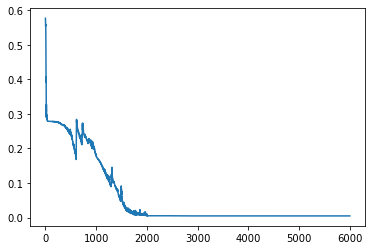

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 6)

tensor(0.1973, device='cuda:0', grad_fn=<SqrtBackward>)

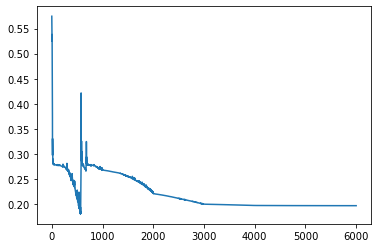

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 5)

tensor(0.0020, device='cuda:0', grad_fn=<SqrtBackward>)

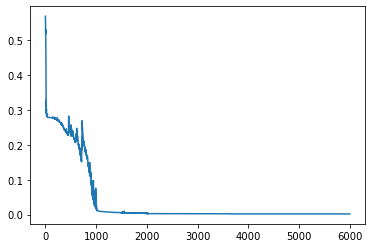

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 4)

tensor(0.2764, device='cuda:0', grad_fn=<SqrtBackward>)

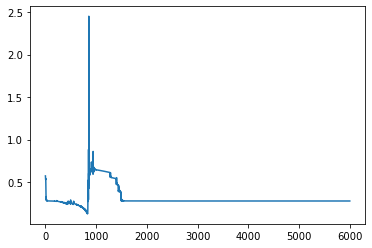

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 3)

tensor(0.2828, device='cuda:0', grad_fn=<SqrtBackward>)

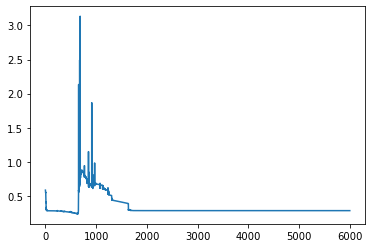

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 2)

tensor(0.2778, device='cuda:0', grad_fn=<SqrtBackward>)

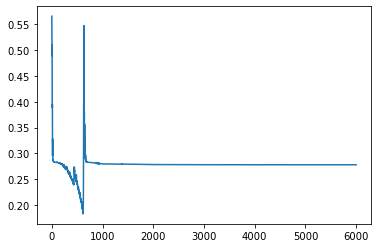

In [7]:
plt.plot(losses)
losses[-1]

#### Using Ranger as Optimizer at 0.1 LR (Trial 1)

tensor(0.2528, device='cuda:0', grad_fn=<SqrtBackward>)

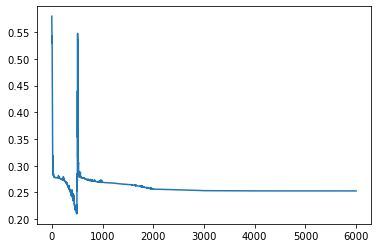

In [7]:
plt.plot(losses)
losses[-1]

#### Using Adam as Optimizer at 0.01 LR (Similar Loss Curve over Runs)

tensor(0.2728, device='cuda:0', grad_fn=<SqrtBackward>)

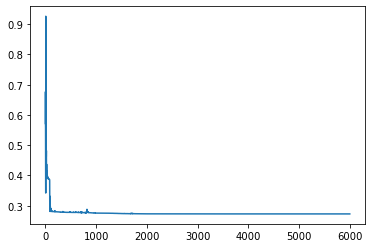

In [8]:
plt.plot(losses)
losses[-1]

In [9]:
x[0, 3:6]

tensor([[0.3187, 0.7125, 0.6125, 0.3438],
        [0.9062, 0.6062, 0.5437, 0.8219],
        [0.1562, 0.4031, 0.2438, 0.1781]], device='cuda:0')

In [10]:
outputs[0, 3:6]

tensor([[0.3887, 0.4425, 0.5255, 0.5263],
        [0.5327, 0.6401, 0.4037, 0.6437],
        [0.5158, 0.6734, 0.3769, 0.6643]], device='cuda:0',
       grad_fn=<SliceBackward>)

#### Size of Decoder Matters

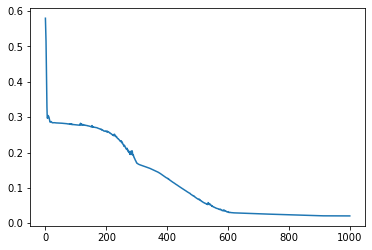

In [7]:
plt.plot(losses)

In [8]:
losses[-1]

tensor(0.0208, device='cuda:0', grad_fn=<SqrtBackward>)

In [9]:
losses[-1]

tensor(0.0024, device='cuda:0', grad_fn=<SqrtBackward>)

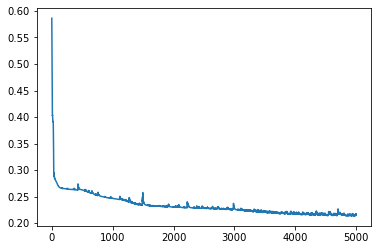

In [7]:
plt.plot(losses);

### Consequence when you use a small Decoder (relative to Encoder)

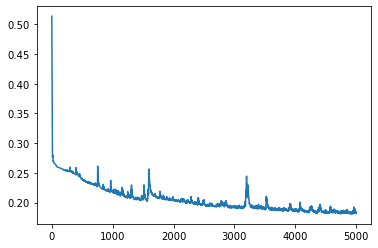

In [7]:
plt.plot(losses);